1. cell type 
2. coarse cell type

check elbo between wrong and correct ones

In [1]:
cd /home/mffang/workspace/Poisson-regression

/home/mffang/workspace/Poisson-regression


In [2]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from RADOM.inference import Trajectory
from RADOM.mixtures import PoissonMixture, GammaPoissonMixture
from RADOM.preprocess import *
from RADOM.plotting import *

In [3]:
from scipy.stats import spearmanr, norminvgauss, invgauss, expon
import scanpy as sc
import anndata as ad
import loompy as lp
import h5py 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm
import copy

In [4]:
import numpy.ma as ma

def plot_cor(A,B):
    a = ma.masked_invalid(A)
    b = ma.masked_invalid(B)
    msk = (~a.mask & ~b.mask)
    X = A[msk]
    Y = B[msk]
    plt.loglog(A[msk],A[msk],'k')
    plt.plot(A[msk],B[msk],'.', \
           label="CCC="+str(np.round(CCC(X,Y),2))\
             +"\nPearson's r="+str(np.round(np.corrcoef(X,Y)[0,1],2)));
    plt.legend(fontsize=15)

# EDA

## Load counts

In [ ]:
data_dir = '/home/ggorin/count_data/poisson_regression/schiebinger/'

attribute_names=[("unspliced", "spliced"), "gene_name", "barcode"]
layer_names, gene_attr, cell_attr = attribute_names
DATASET_NAMES=('D75_Dox_C1', 'D8_Dox_C1' ,'D825_serum_C1', 'D85_serum_C1' ,'D875_serum_C1', 'D9_serum_C1', 'D95_serum_C1')
DATASET_TIME = (7.5,8,8.25,8.5,8.75,9,9.5)

Data = None
gene_names = None
barcodes = []
time = []
for k,d in enumerate(DATASET_NAMES):
    with lp.connect(data_dir+'{}/counts_unfiltered/adata.loom'.format(d), mode="r") as ds:
        layers = [ds.layers[layer][:] for layer in layer_names]
        
        ## Check gene_names are the same
        if gene_names is None:
            gene_names = ds.ra[gene_attr]
        else:
            assert(np.all(gene_names == ds.ra[gene_attr]))
            
        ## Append counts
        if Data is None:
            Data = np.asarray(layers,dtype=int).T
            n = len(Data)
        else:
            data = np.asarray(layers,dtype=int).T
            n = len(data)
            Data = np.append(Data, data, axis=0)
            
        ## Add cell barcodes and cell times
        barcodes.append(ds.ca[cell_attr])
        time.append(np.repeat(DATASET_TIME[k],n))
        
barcodes = np.concatenate(barcodes).ravel()
time = np.concatenate(time).ravel()

In [ ]:
adata = ad.AnnData(Data.sum(axis=-1))
adata.layers["unspliced"]=Data[:,:,0]
adata.layers["spliced"]=Data[:,:,1]
adata.obs["barcode"]=barcodes
adata.obs["time"]=time
adata.var["genes"]=gene_names
adata

In [ ]:
adata.write_loom('./data/Schiebinger.loom')

In [5]:
adata = sc.read('./data/Schiebinger.loom',validate=False)
adata

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 12287 × 32285
    obs: 'barcode', 'obs_names', 'time'
    var: 'genes', 'var_names'
    layers: 'matrix', 'spliced', 'unspliced'

In [6]:
adata.var_names = adata.var['genes'].astype(str)
adata.var_names_make_unique()

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, min_counts=2000)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 11957 × 17102
    obs: 'barcode', 'obs_names', 'time', 'n_genes', 'n_counts'
    var: 'genes', 'var_names', 'n_cells'
    layers: 'matrix', 'spliced', 'unspliced'

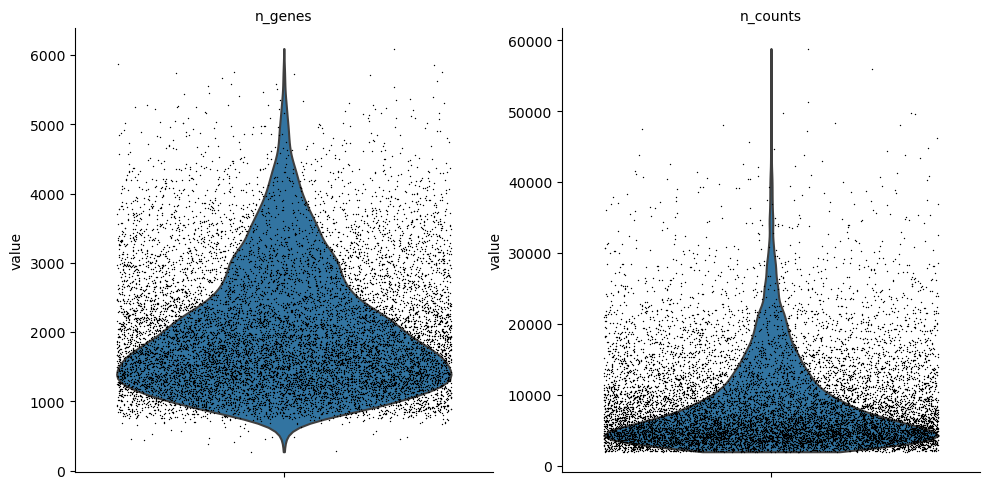

In [8]:
sc.pl.violin(adata, ['n_genes', 'n_counts'],jitter=0.4, multi_panel=True)

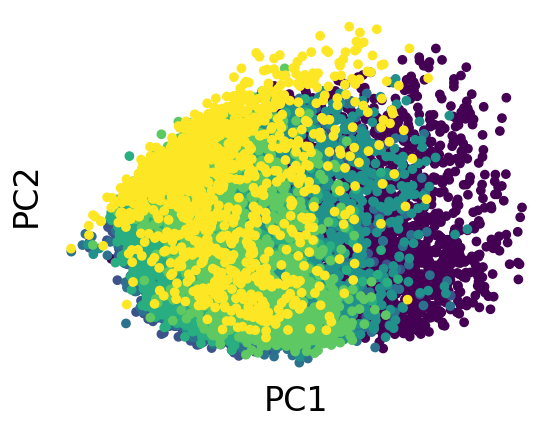

In [9]:
from sklearn.decomposition import PCA

total_UMI = adata.X.toarray().sum(axis=1)
r = total_UMI/np.mean(total_UMI)
pca = PCA(n_components=2)
x = pca.fit_transform(np.log(1+10000*adata.X.toarray()/total_UMI[:,None]*np.mean(total_UMI)))

fig, ax = plt.subplots(1,1)
ax.scatter(x[:,0],x[:,1],c=adata.obs['time']);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

adata.obsm['X_pca'] = x

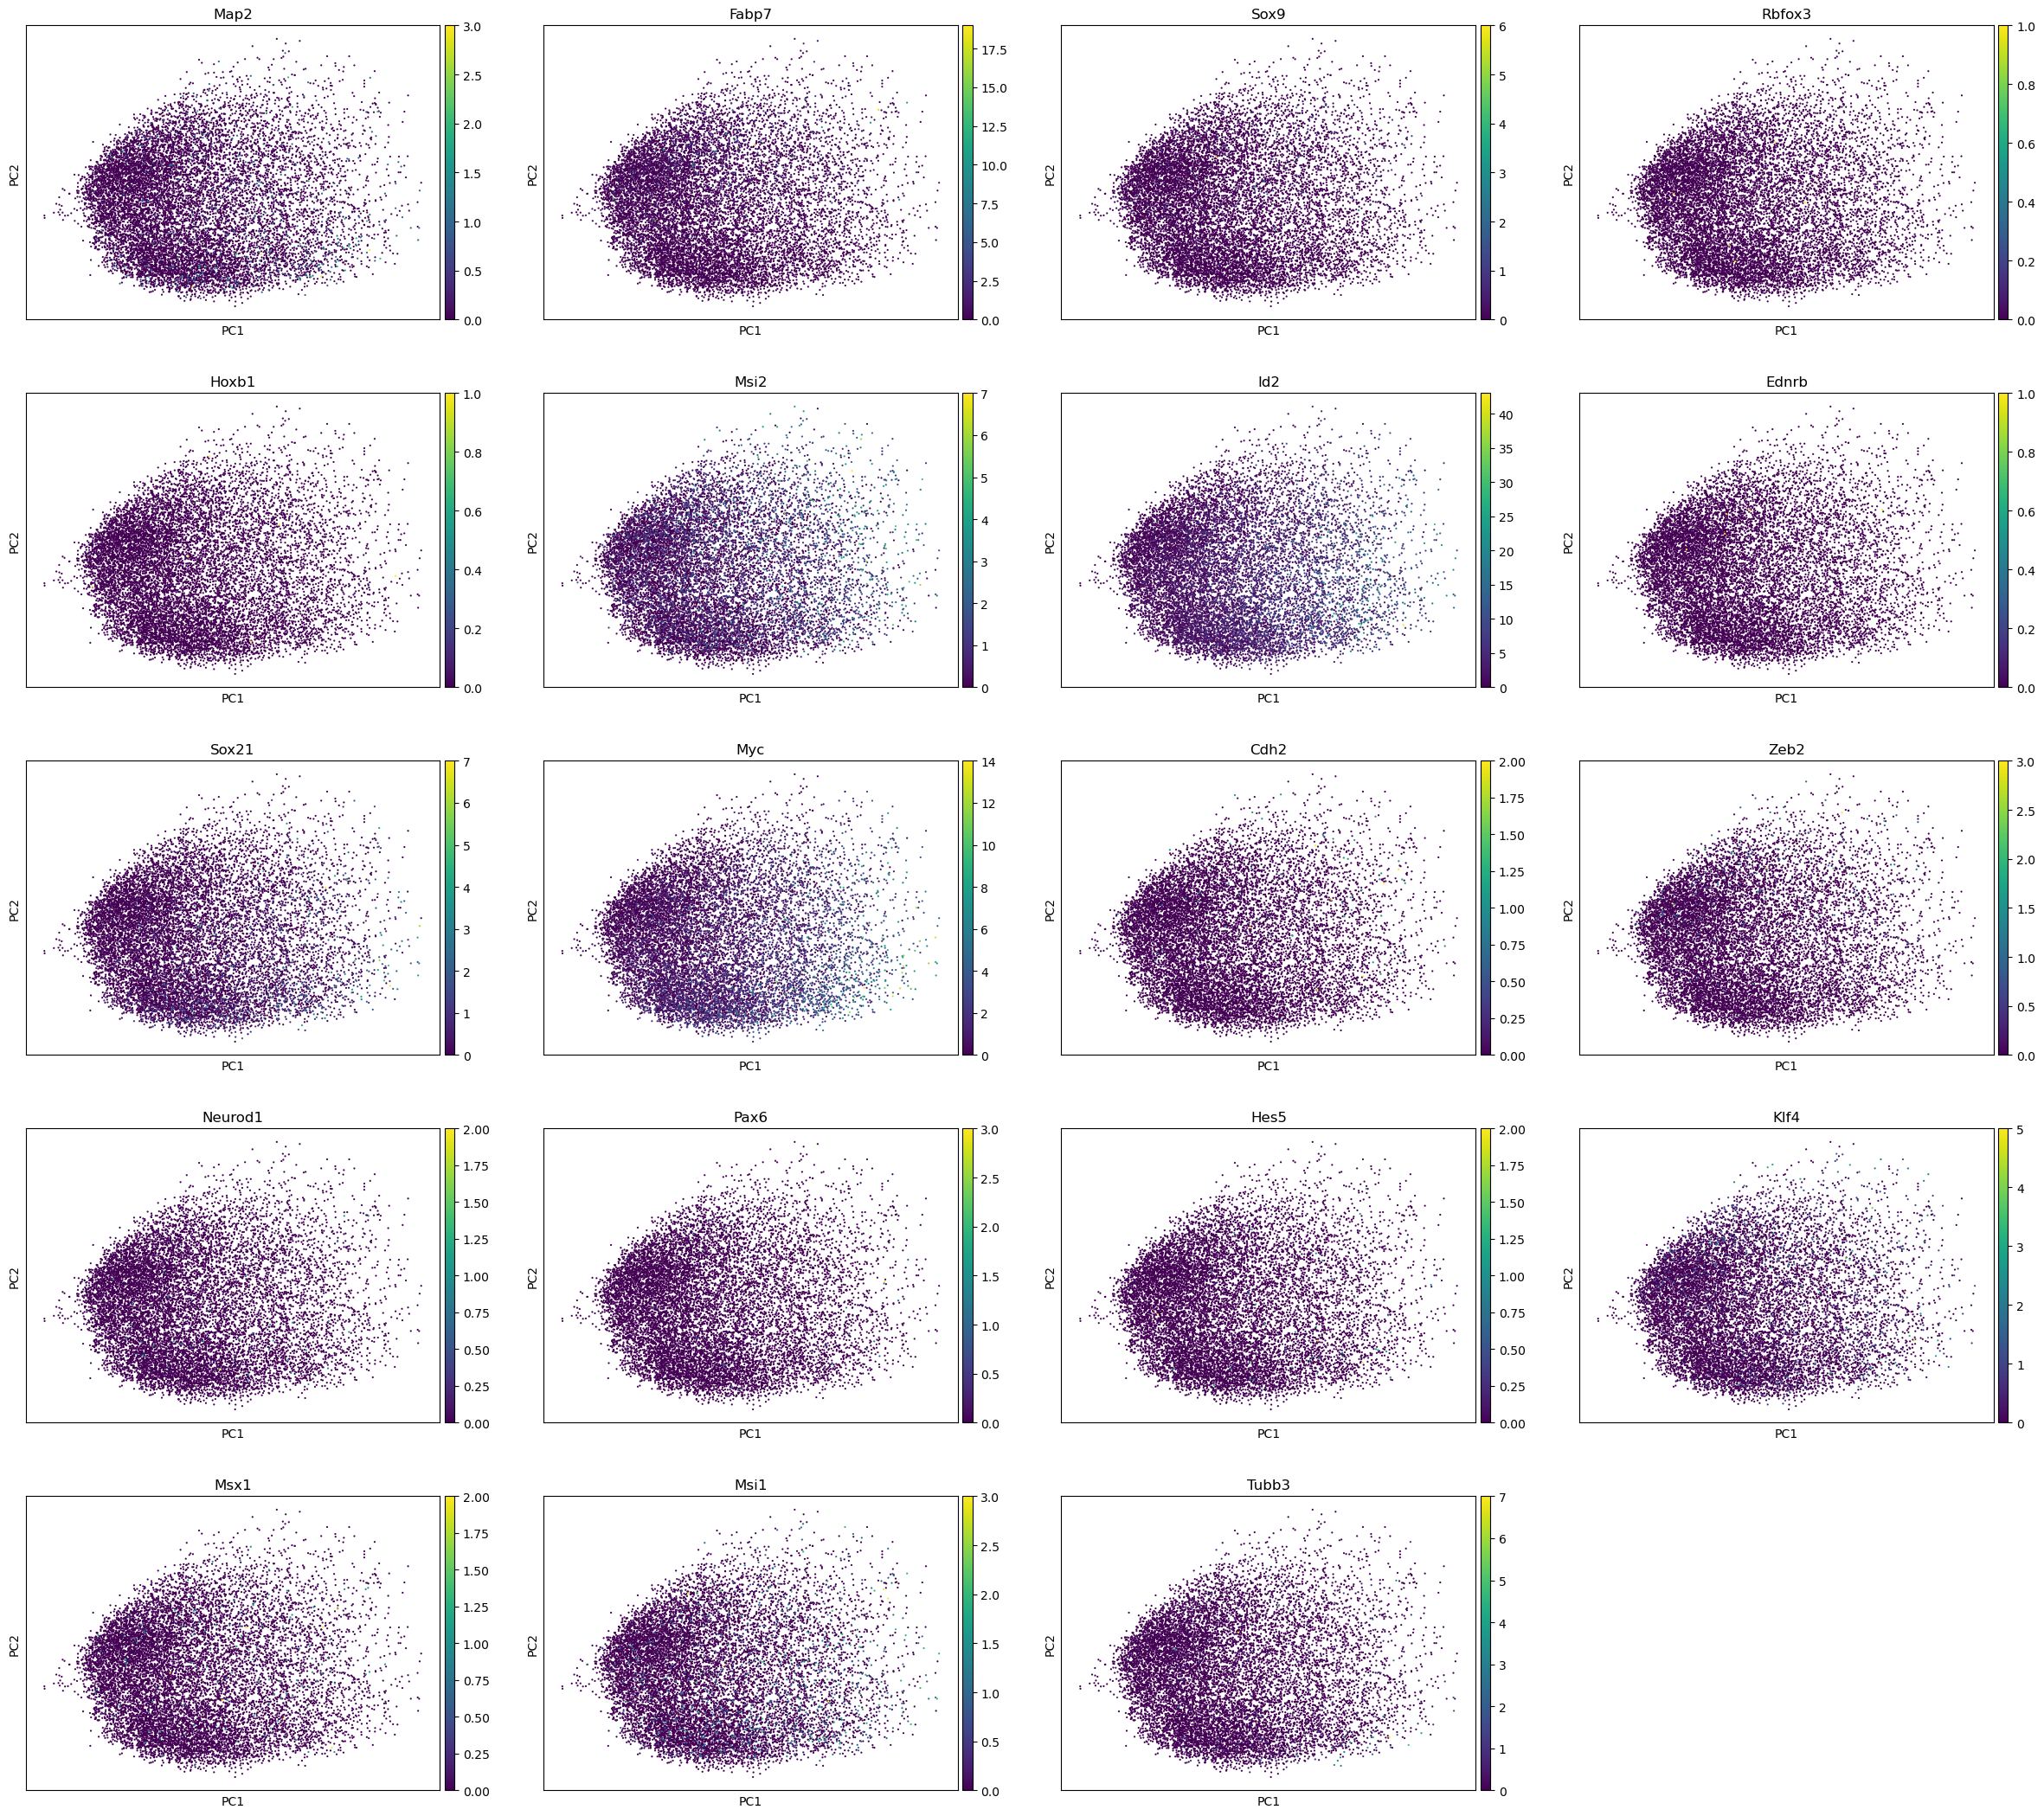

In [10]:
selected_genes = ["Sox2", "Oct4", "Klf4", "Myc","Vtn","Ednrb","Sox21",'Zeb2',
                  'Hes5','Fabp7','Sox1','Neurod1','Pax3','Pax6','Cdh2','Sox9','Sox2',
                  'Id2','Hoxb1','Msx1','Msi1','Msi2','Atoh1','Rbfox3','Map2','Tubb3']
marker_genes = adata.var_names[adata.var_names.isin(selected_genes)]
#plot_marker_genes = ['Cd34','Gata1','Klf1','Gata2','Ldb1']
# Spn==Cd43
sc.pl.pca(adata,color=marker_genes)

In [11]:
times = adata.obs["time"].astype(float)
clusters = (times - 7.75) * 4
clusters[clusters < 0] =  0
clusters[clusters > 6] =  6
clusters = clusters.astype(int)
Clusters = set(clusters)
Clusters

{0, 1, 2, 3, 4, 5, 6}

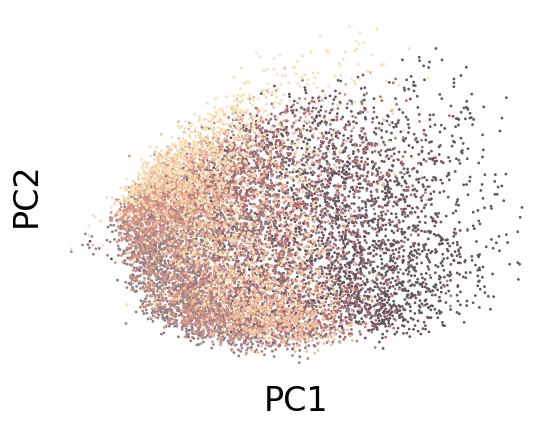

In [12]:
color_palette = ["#66545e","#a39193","#aa6f73","#eea990","#f6e0b5"]
from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(Clusters))

cell_colors = cmap_cluster(clusters)

fig, ax = plt.subplots(1,1)
ax.scatter(x[:,0],x[:,1],c=cell_colors,s=1);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

## Degradation rates from RNA metabolic labeling papers

In [13]:
# TimeLaspe-seq mouse embryonic fibroblast cells
file_path = 'data/Schofield_ST2.xlsx'
Schofield = pd.read_excel(file_path,sheet_name='Table S2_MEF')

# Calculate decay rate
Schofield['Decay Rate'] = np.log(2) / Schofield['mean_half_life']
Schofield = Schofield[~Schofield['Decay Rate'].isna()]

Schofield.head()

gene_name = adata.var_names.tolist()

Schofield_gamma = []
data_genes = np.array(Schofield['transcript'].tolist())
data_rates = np.array(Schofield['Decay Rate'].tolist())
nan = 0 

for gene in gene_name:
    if gene in data_genes:
        idx = np.where(data_genes==gene)[0][0]
        Schofield_gamma.append(data_rates[idx])
    else:
        Schofield_gamma.append(np.nan)
        nan += 1
        
Schofield_gamma = np.array(Schofield_gamma)
nan 

14191

In [14]:
# 2011 Natrue mouse fibroblasts
file_path = 'data/Selbach_ST3.xls'
df = pd.read_excel(file_path)

# Split gene names and create a new DataFrame
gene_names = df['Gene Names'].astype(str).str.split(';')
expanded_df = df.loc[df.index.repeat(gene_names.apply(len))]
expanded_df['Gene Name'] = np.concatenate(gene_names)

# Calculate decay rate
expanded_df['Decay Rate'] = np.log(2) / expanded_df['mRNA half-life average [h]']
expanded_df = expanded_df[~expanded_df['Decay Rate'].isna()]

# Filter and select relevant columns
Selbach = expanded_df[['Gene Name', 'Decay Rate']]

# Print the resulting DataFrame
Selbach.head()


Selbach_gamma = []
data_genes = np.array(Selbach['Gene Name'].tolist())
data_rates = np.array(Selbach['Decay Rate'].tolist())
nan = 0 

for gene in gene_name:
    if gene in data_genes:
        idx = np.where(data_genes==gene)[0][0]
        Selbach_gamma.append(data_rates[idx])
    else:
        Selbach_gamma.append(np.nan)
        nan += 1
        
Selbach_gamma = np.array(Selbach_gamma)
print(nan)

12881


## Gene variance

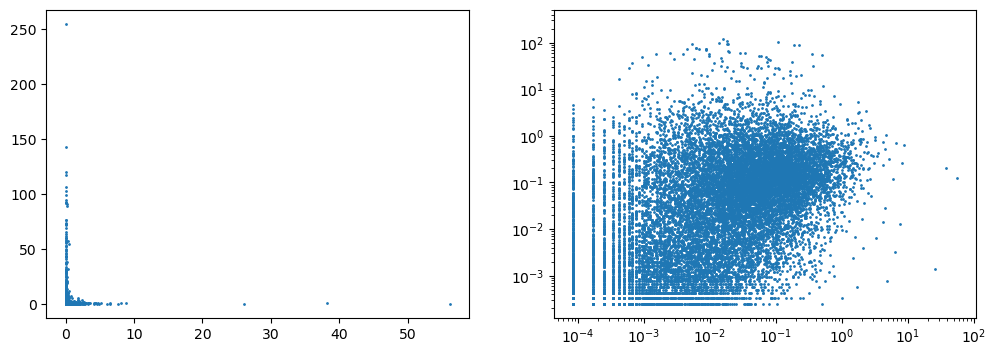

In [15]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [16]:
idx = (adata.layers["unspliced"].toarray().mean(0) > 0) 
U = adata.layers["unspliced"][:,idx].toarray()
n,p = U.shape
X = U
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
su = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total U counts =", str(su))


idx = adata.layers["spliced"].toarray().mean(0) > 0
S = adata.layers["spliced"][:,idx].toarray()
n,p = S.shape
X = S
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
ss = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total S counts =", str(ss))

idx = (adata.layers["spliced"].toarray().mean(0) > 0) | (adata.layers["unspliced"].toarray().mean(0) > 0)
U=adata.layers["unspliced"][:,idx].toarray()
S=adata.layers["spliced"][:,idx].toarray()
X = S + U
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s1 = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total counts =", str(s1))

X = U + S
X_total = X.sum(1)
s2 = (X_total.var()-X_total.mean())/X_total.mean()**2
print("s estimated by total counts =", str(s2))

s estimated by normalized covariance of total U counts = 0.8848289192330681
s estimated by normalized covariance of total S counts = 0.6114948168530666
s estimated by normalized covariance of total counts = 0.6570867742426546
s estimated by total counts = 0.5800781649544566


s estimated by normalized covariance of Poission genes = 0.5800781649544566


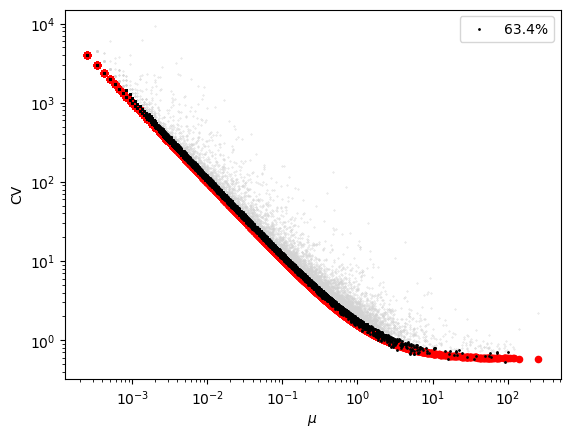

In [17]:
a=1
s=s2

X_bar = np.mean(U + S, axis=0)
X_var = np.var(U + S, axis=0)

Pgene_mask = (X_mean > 0) & (X_var/(a*X_mean + s*X_mean**2) < 1.2)
idx = (adata.layers["spliced"].toarray().mean(0) > 0) | (adata.layers["unspliced"].toarray().mean(0) > 0)
Pgenes = adata.var_names[idx][Pgene_mask]

P = (S + U)[:,Pgene_mask]
n,p = P.shape
#P_cov = np.cov(P,rowvar=False)
#P_mean = np.mean(P,axis=0)
#P_rho = P_cov/P_mean[:,None]/P_mean[None,:]
#s = (np.sum(P_rho)-np.sum(np.diag(P_rho)))/((p-1)*p)
print("s estimated by normalized covariance of Poission genes =", str(s))

plt.scatter(X_bar, a/X_bar + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

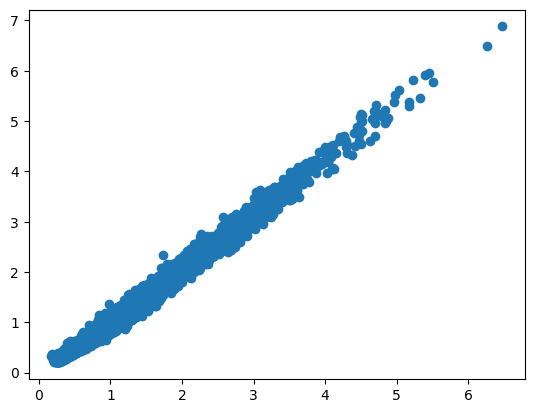

In [18]:
total =  (U + S).mean(1)/(U + S).mean()

rd = (U + S)[:,Pgene_mask].mean(1)/(U + S)[:,Pgene_mask].mean()

plt.figure()
plt.scatter(rd,total)

## Select genes

In [103]:
var_threshold = 1.2
U_mean = adata.layers["unspliced"].toarray().mean(0)
S_mean = adata.layers["spliced"].toarray().mean(0)
U_var = adata.layers["unspliced"].toarray().var(0)
S_var = adata.layers["spliced"].toarray().var(0)
fitted_idx = (U_mean > 0.1) & (S_mean > 0.1) \
    & (U_var/(a*U_mean + s2*U_mean**2) > var_threshold) \
    & (S_var/(a*S_mean + s2*S_mean**2) > var_threshold) \
    & (np.abs(np.log(S_mean/U_mean)) < 4)
fitted_genes=adata.var_names[fitted_idx]
len(fitted_genes)

/tmp/ipykernel_3272939/2024459559.py:7: RuntimeWarning: invalid value encountered in divide
  & (U_var/(a*U_mean + s2*U_mean**2) > var_threshold) \
/tmp/ipykernel_3272939/2024459559.py:9: RuntimeWarning: divide by zero encountered in divide
  & (np.abs(np.log(S_mean/U_mean)) < 4)


635

In [104]:
cell_cycle_genes = np.loadtxt("data/cell_cycle_genes.txt",dtype="str")
fitted_genes = fitted_genes[~fitted_genes.isin(cell_cycle_genes)]
len(fitted_genes)

552

548


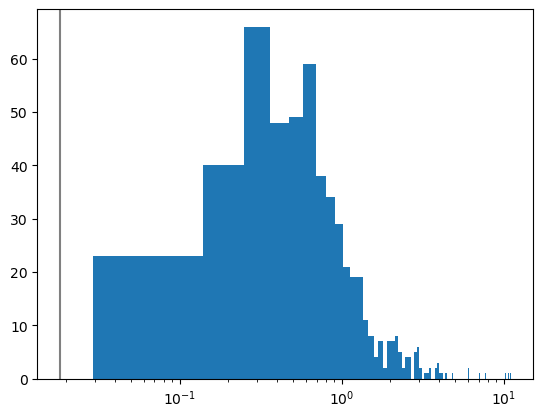

In [105]:
gene_length_file = np.loadtxt("data/gg_200524_mouse_genome_polyA_cum_1.txt",dtype="str")
gene_length = np.array([int(gene[1]) for gene in gene_length_file])
gene_name = np.array([gene[0] for gene in gene_length_file])

fitted_genes = fitted_genes[fitted_genes.isin(gene_name)]
fitted_idx = adata.var_names.isin(fitted_genes)
print(len(fitted_genes))

Ub_gene_idx = np.array([ np.where(gene_name == fitted_gene)[0][0]  for fitted_gene in fitted_genes ])
Ub = 10**(-5)*gene_length[Ub_gene_idx]
plt.hist(Ub,bins=100);
plt.xscale('log')
plt.axvline(x=np.e**(-4),color='gray');

/tmp/ipykernel_3272939/2237496637.py:8: RuntimeWarning: divide by zero encountered in divide
  ax[0].scatter(U_mean, a/U_mean + s2, c='r', s=20)
/tmp/ipykernel_3272939/2237496637.py:9: RuntimeWarning: invalid value encountered in divide
  ax[0].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=1)


(11957, 548, 2)

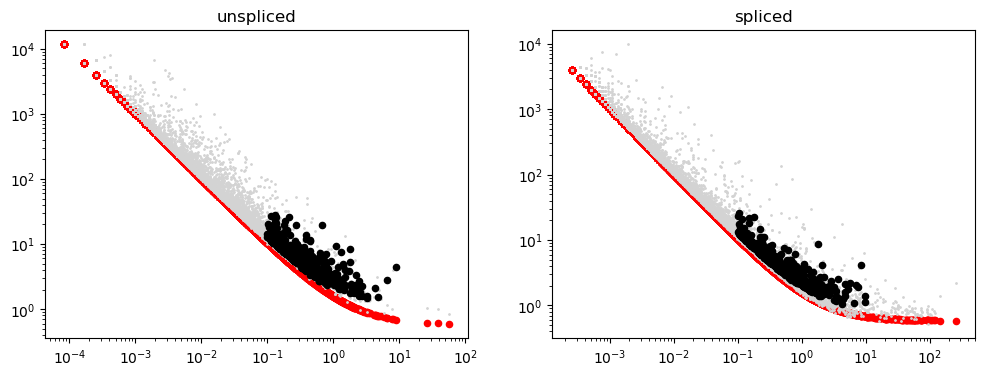

In [106]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[1].scatter(S_mean, a/S_mean + s2, c='r', s=20)
ax[1].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=1)
ax[1].scatter(S_mean[fitted_idx], S_var[fitted_idx]/S_mean[fitted_idx]**2, c='k', s=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('spliced')
ax[0].scatter(U_mean, a/U_mean + s2, c='r', s=20)
ax[0].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=1)
ax[0].scatter(U_mean[fitted_idx], U_var[fitted_idx]/U_mean[fitted_idx]**2, c='k', s=20)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('unspliced')

X=np.zeros((n,fitted_idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,fitted_idx].toarray()
X[:,:,1]=adata.layers["spliced"][:,fitted_idx].toarray()
fitted_genes=adata.var_names[fitted_idx]
X.shape

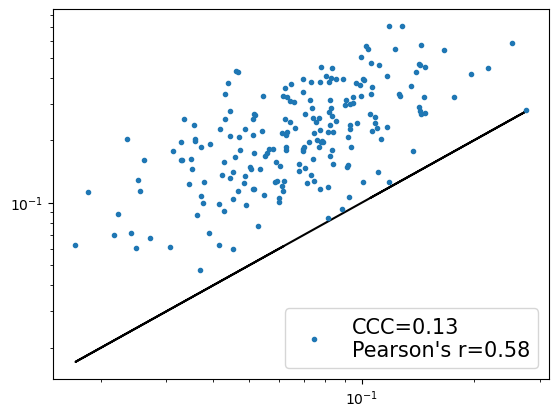

In [107]:
plot_cor(Selbach_gamma[fitted_idx],Schofield_gamma[fitted_idx])

In [108]:
plot_idx = [np.where(fitted_genes==gene)[0] for gene in marker_genes]
plot_idx = np.concatenate(plot_idx).ravel()

if len(plot_idx) == 0:
    plot_idx =np.arange(10)
print(fitted_genes[plot_idx])

Index(['AC149090.1', 'Arpc2', 'Nrp2', 'Ncl', 'Serpine2', 'Ubxn4', 'Cd55',
       'Csrp1', 'Lamc1', 'Lamc2'],
      dtype='object', name='genes')


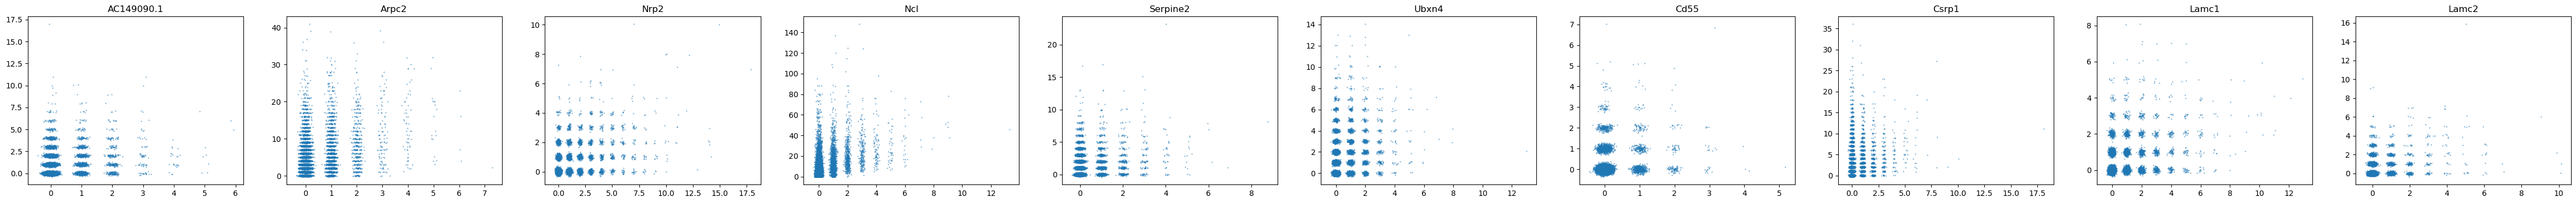

In [109]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

## Mixtures fitting

In [110]:
cell_idx = clusters.isin(Clusters)
X_mix = X[cell_idx]

1 -976.5107448503929 -976.6024066384668 -976.9410544216596
2 -938.3146568156765 -938.4980640248426 -939.1756685764318
3 -925.3408318092996 -925.615984439558 -926.6325457595436
4 -914.3119169481087 -914.6788149994593 -916.0343330878413
5 -908.5665185884973 -909.0251620609401 -910.7196369177186
6 -904.6195840136502 -905.1699729071853 -907.2034045323602


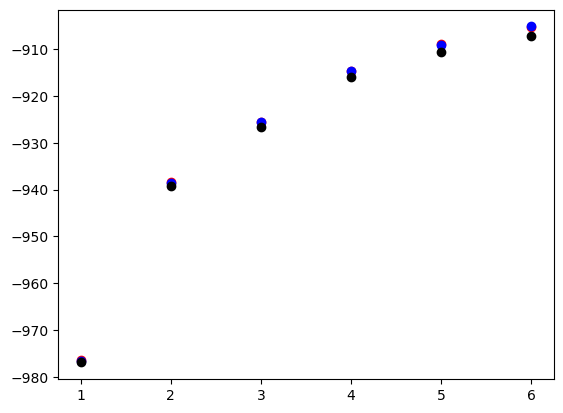

In [111]:
PMs = []
for nc in range(1,7):
    PM = PoissonMixture(n_components=nc,verbose=0)
    Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=5,n_init=3)
    PMs.append(PM)
    plt.scatter(nc,elbo,color='r')
    plt.scatter(nc,PM.compute_AIC(X_mix),color='b')
    plt.scatter(nc,PM.compute_BIC(X_mix),color='k')
    print(nc,PM.compute_lower_bound(X_mix),PM.compute_AIC(X_mix),PM.compute_BIC(X_mix))

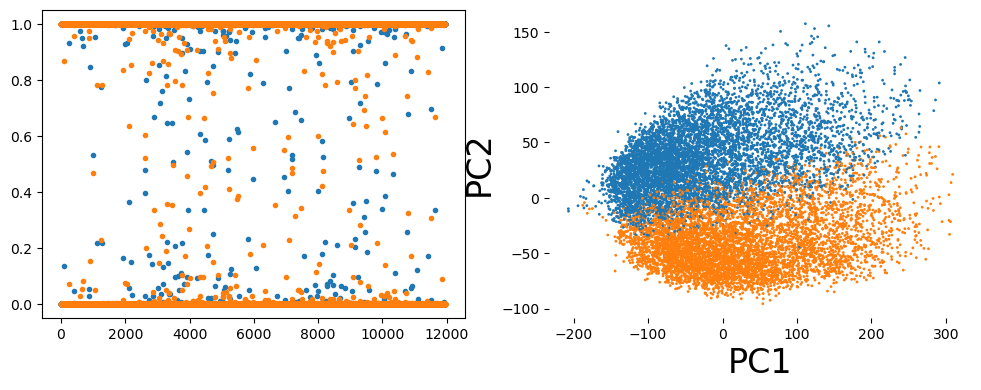

In [112]:
PM = PoissonMixture(n_components=2,verbose=0)
Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=10,n_init=5)
PM.weights

tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters[cell_idx])],'.');
ax[1].scatter(x[cell_idx,0],x[cell_idx,1],c=tab_colors[np.argmax(Q,axis=-1)],s=1);
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

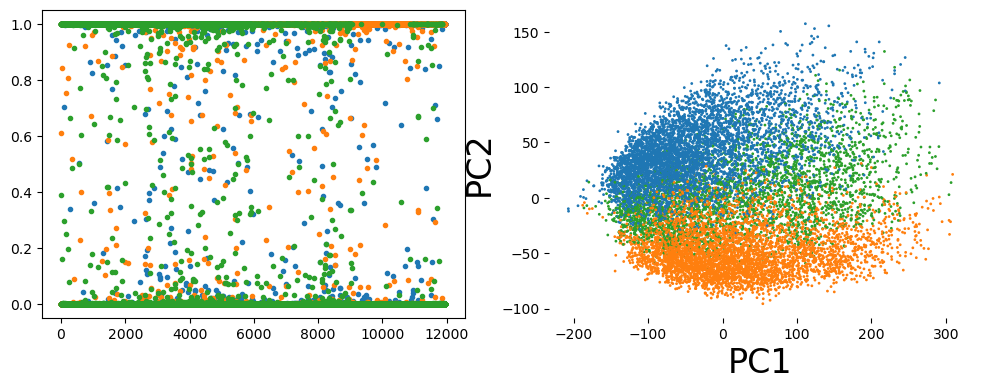

In [113]:
PM = PoissonMixture(n_components=3,verbose=0)
Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=10,n_init=5)
PM.weights

tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters[cell_idx])],'.');
ax[1].scatter(x[cell_idx,0],x[cell_idx,1],c=tab_colors[np.argmax(Q,axis=-1)],s=1);
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

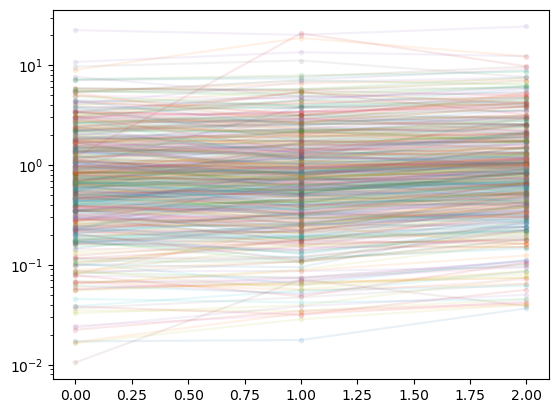

In [114]:
gbr = PM.theta[:,:,0]/PM.theta[:,:,1]

plt.plot(gbr,'.-',alpha=0.1);
plt.yscale('log')

## Filter genes

In [115]:
weird_idx = np.where(gbr.max(0)/gbr.min(0)>100)[0]
fitted_genes[weird_idx]

Index([], dtype='object', name='genes')

In [116]:
constant_idx = np.where(gbr.max(0)/gbr.min(0)<100)[0]

fitted_genes = fitted_genes[constant_idx]
fitted_idx = adata.var_names.isin(fitted_genes)

X = X[:,constant_idx]
Ub = Ub[constant_idx]
plot_idx = [np.where(fitted_genes==gene)[0] for gene in marker_genes]
plot_idx = np.concatenate(plot_idx).ravel()
print(fitted_genes[plot_idx])
X.shape

Index([], dtype='object', name='genes')


(11957, 548, 2)

# Trajectory fitting

In [117]:
elbos = {}
params_Ub={'r':rd,"Ub":Ub,"lambda_tau":0,"lambda_a":0}
params={'r':rd,"lambda_tau":0,"lambda_a":0}

## Fine cluster

In [118]:
Timepoints = [7.5,8.0,8.25,8.5,8.75,9,9.5]

m=151
weight0 = 0*np.ones((adata.n_obs,m))
for i,Time in enumerate(Timepoints):
    idx = times.isin([Time])
    if Time<=8:
        weight0[idx,0] += 1
    else:
        weight0[idx,int(100*(Time-8))] += 1
weight0 = weight0/weight0.sum(axis=1,keepdims=True)
Q0 = weight0[:,None]

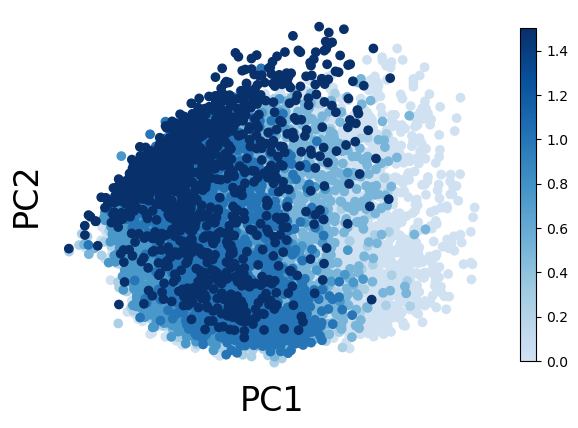

In [119]:
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=weight0@(np.linspace(0,1.5,m).reshape((-1,1))),cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [120]:
topo = np.array([[0,1,2]])
tau = (0,1,2) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=params,Q=Q0,parallel=True,n_threads=4,epoch=100)
print(traj.elbos[-1])
traj_3 = copy.deepcopy(traj)

fitting with warm start


100%|██████████| 100/100 [18:44<00:00, 11.24s/it]


-916.038322912789


In [86]:
traj = traj_3

[0.         0.88543442 2.        ]


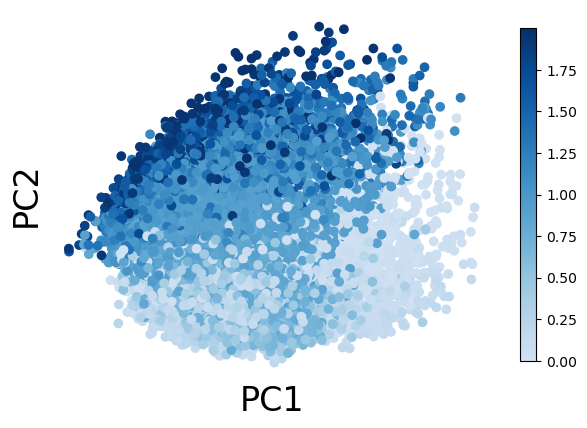

In [87]:
print(traj.tau)
t_hat = traj.Q.sum(1)@traj.t
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=t_hat,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

[]

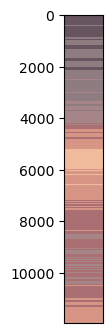

In [88]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,cell_type in enumerate(Clusters):
    idx = clusters.isin([cell_type])
    cluster[idx] = i
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
fig, ax = plt.subplots(1,1,figsize=(0.5,4))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])

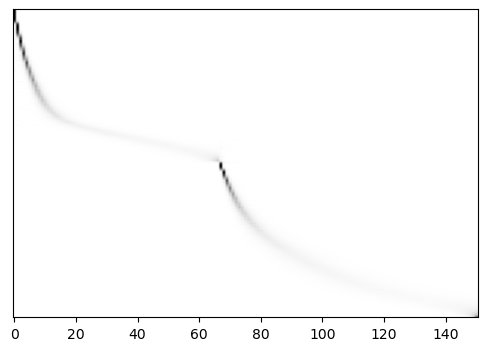

In [89]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax=plot_t(traj,l=0,ax=ax,order_cells=True)
ax.set_yticks([]);

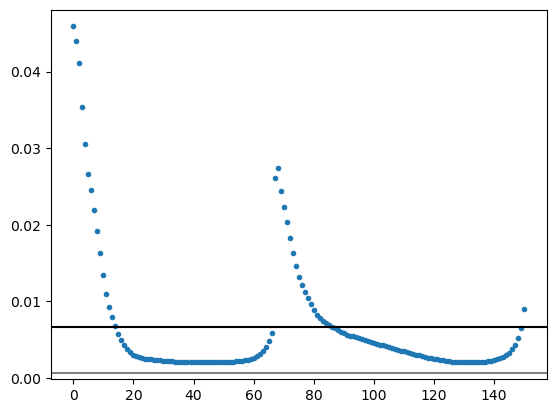

In [90]:
plt.plot(traj.Q[:,0].mean(0),'.')
plt.axhline(y=1/traj.m,c='k')
plt.axhline(y=0.1/traj.m,c='gray')

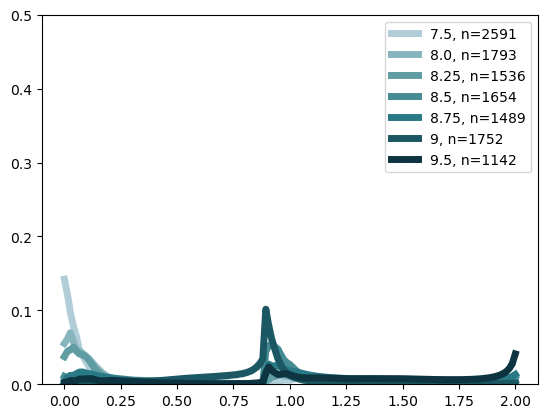

In [91]:
Timepoints = [7.5,8.0,8.25,8.5,8.75,9,9.5]

#color_palette_blue = ["#b3cde0","#6497b1","#005b96","#011f4b"]
#color_palette = ["#daf8e3","#97ebdb","#00c2c7","#0086ad","#005582"]
#color_palette = ["#006666","#008080","#66b2b2","#b2d8d8"]
color_palette = ["#b1cdd8","#5f9da2","#2a7986","#0e3442"]

from matplotlib.colors import LinearSegmentedColormap
timepoint_cmp = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(Timepoints))

for i,timepoint in enumerate(Timepoints):
    idx = adata.obs["time"].isin([timepoint])
    plt.plot(traj.t,traj.Q[idx,0].mean(0),'.-',linewidth=5,label=str(timepoint)+", n="+str(idx.sum()),color=timepoint_cmp(i))
plt.ylim((0,0.5))
plt.legend();

0.3910199325971975
0.5191790844381102
0.6771205364554179
0.7959412285623008
0.9483089446225828
0.8662523987745502
1.2270737053893253


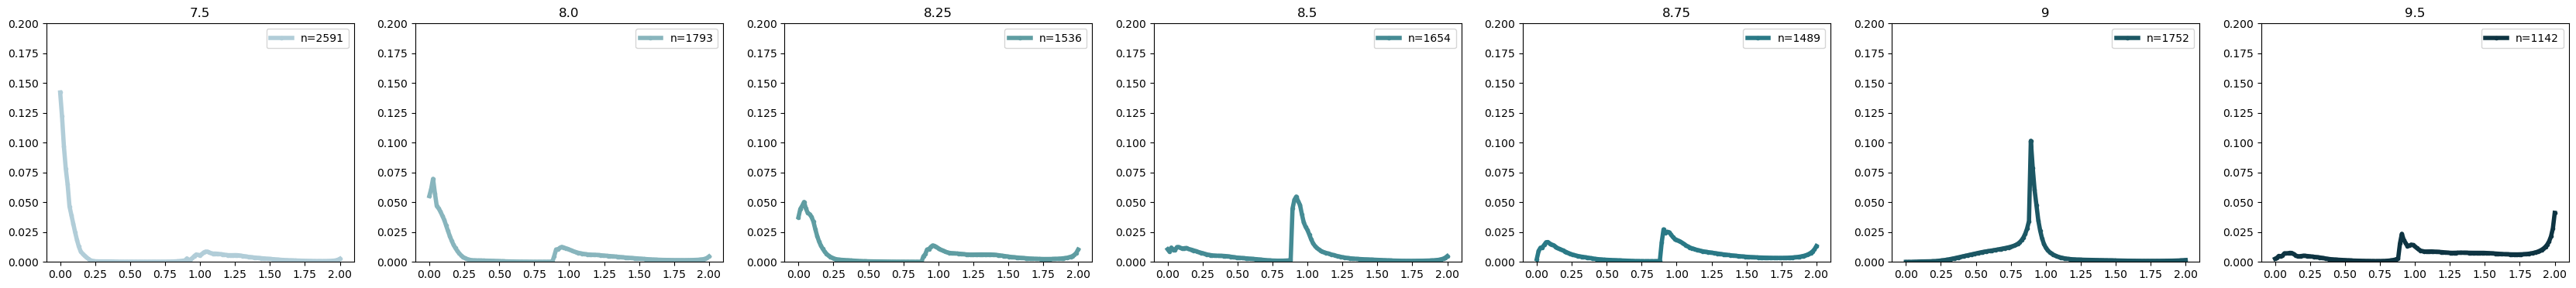

In [92]:
fig, ax = plt.subplots(1,len(Timepoints),figsize=(6*len(Timepoints),4))
for i,timepoint in enumerate(Timepoints):
    idx = adata.obs["time"].isin([timepoint])
    ax[i].plot(traj.t,traj.Q[idx,0].mean(0),'.-',linewidth=4,label="n="+str(idx.sum()),color=timepoint_cmp(i))
    ax[i].set_title(timepoint)
    ax[i].set_ylim((0,0.2))
    ax[i].legend()
    print((traj.Q[idx,0].mean(0)@traj.t).mean())

In [ ]:
Y = traj.get_Y_hat(traj.theta, t_hat, traj.tau, traj.topo, traj.params)[0]
rd_s = traj.params['r'].var()/traj.params['r'].mean()**2
print(rd_s)
mean = X[:,:,1].mean(axis=0)
var = X[:,:,1].var(axis=0)
Y_mean = Y[:,:,1].mean(axis=0)
Y_var = Y[:,:,1].var(axis=0)
plt.loglog(mean,var,'b.')
plt.loglog(Y_mean,rd_s*mean**2+mean+(1+rd_s)*Y_var,'r.')
signal = Y_var
noise = var-rd_s*mean**2-(1+rd_s)*Y_var
unexplained = noise - mean
print((signal/mean).mean(),(noise/mean).mean())

In [ ]:
plt.loglog(traj.theta[:,[-2]],traj.theta[:,[-2]],'-',color='gray');
plt.loglog(traj.theta[:,[-2]],traj.theta[:,[-1]],'.');

In [ ]:
plot_cor(traj.theta[:,-1]/24,Selbach_gamma[fitted_idx])

In [ ]:
plot_cor(traj.theta[:,-1]/24,Schofield_gamma[fitted_idx])

In [ ]:
plot_y(traj,X=X/rd[:,None,None],idx=np.arange(10),gene_name=fitted_genes);

In [ ]:
plot_phase(traj,X=X,idx=np.arange(10),gene_name=fitted_genes);

In [ ]:
n, p, _ = X.shape
up_mask = (traj.theta[:,2] > traj.theta[:,1]) & (traj.theta[:,1] > traj.theta[:,0])
print(up_mask.sum())
up_idx = np.arange(p)[up_mask]
plot_y(traj,X=X/rd[:,None,None],idx=up_idx[:10],gene_name=fitted_genes);

In [ ]:
marker_genes = ['Gata1','Gata2','Hba-x']

In [ ]:
fig,ax = plt.subplots(1,len(marker_genes),figsize=(6*len(marker_genes),4))
for i,gene in enumerate(marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"].toarray()[:,j]/rd,adata.layers["spliced"].toarray()[:,j]/rd,c=traj.Q[:,0]@traj.t)

In [ ]:
fig,ax = plt.subplots(2,len(marker_genes),figsize=(6*len(marker_genes),8))
for i,gene in enumerate(marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

In [ ]:
p = X.shape[1]
fig,ax = plt.subplots(1,1)
for j in range(p):
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='gray')
for j in plot_idx:
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='red')

x_label_list = ['α0', 'α1', 'α2']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)
#plt.yscale('log')

In [ ]:
#from scipy.spatial import distance

#S = data.X.toarray()
#dist = distance.cdist(S, S, 'minkowski', p=1.)

#order = np.argsort(data.obs["t_hat"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

#order = np.argsort(data.obs["celltype"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

## Fitting without prior

In [ ]:
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c='grey',s=10);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

### two_species_ss

In [ ]:
from multiprocessing import Pool

tau = (0,1,2)
topo = np.array([[0,1,2]])
Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,params=params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [ ]:
corrs = []
elbos = []
right_t = Q0[:,0] @ (np.linspace(0,2,m).reshape((-1,1)))
for traj in trajs:
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [ ]:
traj = trajs[np.argmax(elbos)]
print(np.max(elbos),traj.compute_AIC(X_mix,standard=False),traj.compute_BIC(X_mix,standard=False))

In [ ]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [ ]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,cell_type in enumerate(cell_types):
    idx = adata.obs["celltype"].isin([cell_type])
    cluster[idx] = i
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
fig, ax = plt.subplots(1,1,figsize=(0.5,4))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])

In [ ]:
ax = plot_t(traj,l=0,order_cells=True)
x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list);
ax.set_yticks([]);

In [ ]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.')

In [ ]:
stages = ['E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5']
fig, ax = plt.subplots(1,len(stages),figsize=(6*len(stages),4))
for i,stage in enumerate(stages):
    idx = adata.obs["stage"].isin([stage])
    ax[i].plot(traj.t,traj.Q[idx,0].mean(0),'k.-',label="n="+str(idx.sum()))
    ax[i].set_title(stage)
    ax[i].set_ylim((0,0.2))
    ax[i].legend()

In [ ]:
fig, ax = plt.subplots(1,len(Clusters),figsize=(6*len(Clusters),4))
for i,stage in enumerate(Clusters):
    idx = clusters.isin([stage])
    ax[i].plot(traj.t,traj.Q[idx,0].mean(0),'k.-',label="n="+str(idx.sum()))
    ax[i].set_title(stage)
    ax[i].set_ylim((0,0.4))
    ax[i].legend()

In [ ]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes);

In [ ]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes);

In [ ]:
n, p, _ = X.shape
up_mask = (traj.theta[:,2] > 2*traj.theta[:,1]) & (traj.theta[:,1] > 2*traj.theta[:,0])
print(up_mask.sum())
up_idx = np.arange(p)[up_mask]
plot_y(traj,X=X,idx=up_idx[:10],gene_name=fitted_genes);

In [ ]:
fig,ax = plt.subplots(1,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),4))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"].toarray()[:,j]/rd,adata.layers["spliced"].toarray()[:,j]/rd,c=traj.Q[:,0]@traj.t)

In [ ]:
fig,ax = plt.subplots(2,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),8))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

## Synthetic data

In [ ]:
m=100
weight0 = np.zeros((adata.n_obs,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    weight0[idx,int(i*m/len(Clusters)):int((i+1)*m/len(Clusters))] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

topo = np.array([[0,1,2]])
tau = (0,24,48) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=params,Q=Q0,parallel=True,n_threads=10,epoch=100)

In [ ]:
print(traj.elbos[-1])

In [ ]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [ ]:
plot_t(traj,order_cells=True)

In [ ]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum()*traj.m,'.')

In [ ]:
Y = traj.get_Y_hat(theta=traj.theta,t=traj.Q[:,0]@traj.t,tau=traj.tau,topo=traj.topo,params=traj.params)
syn_X = np.random.poisson(rd[:,None,None]*Y[0])
syn_t = traj.Q[:,0]@traj.t
plt.hist(syn_t,bins=traj.t);

In [ ]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(syn_X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),syn_X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

In [ ]:
U_mean = syn_X[:,:,0].mean(0)
U_var = syn_X[:,:,0].var(0)
S_mean = syn_X[:,:,1].mean(0)
S_var = syn_X[:,:,1].var(0)
ss = rd.var()

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(S_mean, a/S_mean + ss, c='r', s=20)
ax[0].scatter(S_mean, S_var/S_mean**2,c='k',alpha=1, s=1)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(U_mean, a/U_mean + ss, c='r', s=20)
ax[1].scatter(U_mean, U_var/U_mean**2,c='k',alpha=1, s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [ ]:
from multiprocessing import Pool

tau = (0,1,2)
topo = np.array([[0,1,2]])

Input_args = []
def fit_wrapper(seed):
    syn_traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    syn_traj = syn_traj.fit(syn_X,m=100,n_init=1,params=params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return syn_traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    syn_trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [ ]:
corrs = []
elbos = []
for syn_traj in syn_trajs:
    right_t = syn_t
    t_hat = syn_traj.Q[:,0] @ syn_traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append(syn_traj.elbos[np.argmax([syn_traj.elbos[i][-1] for i in range(len(syn_traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)